In [1]:
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import re
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import scimap as sm  
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import pearsonr

#set current directory
os.chdir("C:/Users/tav9/Dropbox (HMS)/PCA_phaseII/cycif_analysis_materials/data_e41")
import napari

Running SCIMAP  2.1.0


In [2]:
adata = ad.read("C:/Users/tav9/Dropbox (HMS)/PCA_phaseII/cycif_analysis_materials/data_e41/e41_tumor.h5ad")

C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\anndata\__init__.py:55: FutureWarning:

`anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.



<Axes: >

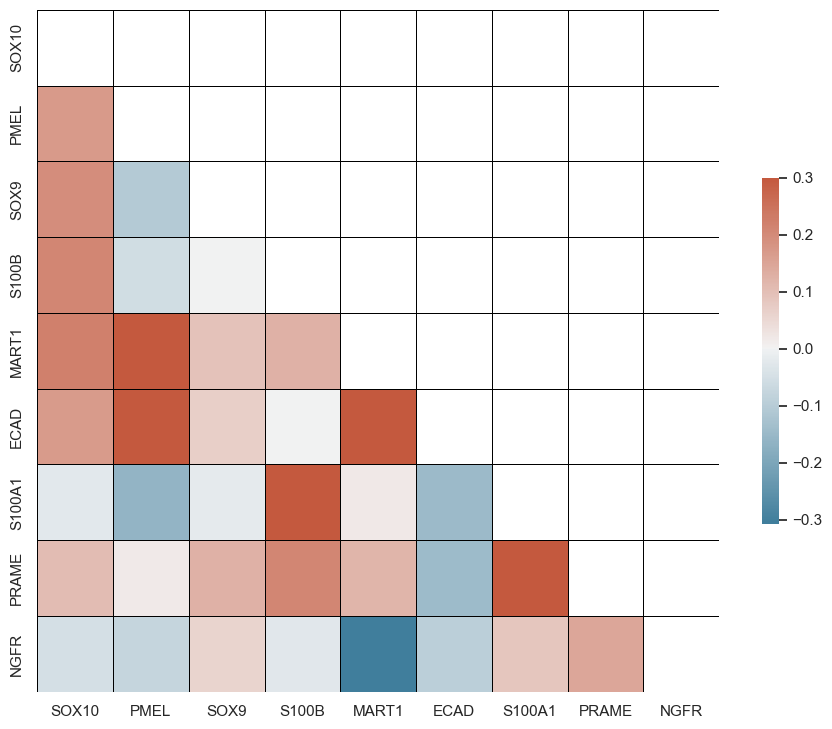

In [6]:
markers = ['DNA1', '5hmC', 'Tet2', 'SOX10', 'LaminA/C/B1', 'PMEL', 'SOX9', 'S100B',
       'MART1', 'aSMA', 'MITF', 'p21', 'panCK', 'ECAD', 'pSTAT1', 'MCM2',
       'S100A1', 'Ki67', 'pSTAT3', 'PD1', 'pH3', 'PRAME', 'IRF5', 'IRF1',
       'B2M', 'MX1', 'CD11c', 'NGFR', 'CK14', 'LDH', 'pERK', 'BCL2', 'VIM',
       'CD3e', 'pS6', 'CCND1', 'CCNA2', 'PCNA', 'DNA12', 'p16/CDKN2A', 'HIF1a',
       'H3k27me3']


d=pd.DataFrame(adata.X, columns = markers)
d=pd.DataFrame.drop(d, columns=['DNA1', 'LaminA/C/B1', '5hmC', 'Tet2', 
       'aSMA', 'MITF', 'p21', 'panCK', 'pSTAT1', 'MCM2',
       'Ki67', 'pSTAT3', 'PD1', 'pH3', 'IRF5', 'IRF1',
       'B2M', 'MX1', 'CD11c', 'CK14', 'LDH', 'pERK', 'BCL2', 'VIM',
       'CD3e', 'pS6', 'CCND1', 'CCNA2', 'PCNA', 'DNA12', 'p16/CDKN2A', 'HIF1a',
       'H3k27me3'])
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True,  annot=False,linewidths=.5, linecolor='black', cbar_kws={"shrink": .5})
#plt.savefig("C:/Users/tav9/Dropbox (HMS)/PCA_phaseII/cycif_analysis_materials/data_e41/correlation_prame_5hmc.pdf", format="pdf", bbox_inches="tight")


Annotation Matrix for Heatmap (only asterisks):
       SOX10 PMEL SOX9 S100B MART1 ECAD S100A1 PRAME NGFR
SOX10           *    *     *     *    *      *     *    *
PMEL       *         *     *     *    *      *     *    *
SOX9       *    *                *    *      *     *    *
S100B      *    *                *           *     *    *
MART1      *    *    *     *          *      *     *    *
ECAD       *    *    *           *           *     *    *
S100A1     *    *    *     *     *    *            *    *
PRAME      *    *    *     *     *    *      *          *
NGFR       *    *    *     *     *    *      *     *     


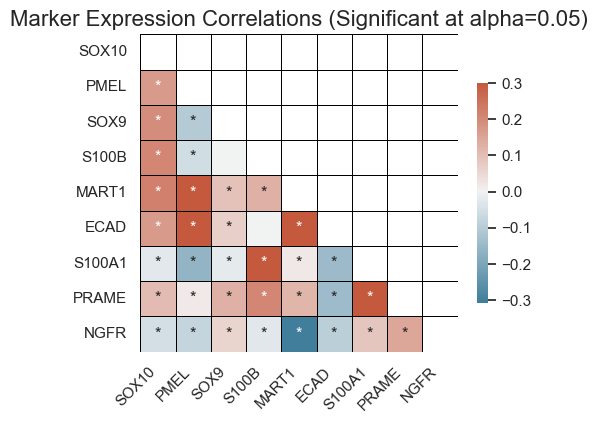

In [15]:
d = pd.DataFrame(adata.X, columns=markers)
markers_to_drop = [
    'DNA1', 'LaminA/C/B1', '5hmC', 'Tet2',
    'aSMA', 'MITF', 'p21', 'panCK', 'pSTAT1', 'MCM2',
    'Ki67', 'pSTAT3', 'PD1', 'pH3', 'IRF5', 'IRF1',
    'B2M', 'MX1', 'CD11c', 'CK14', 'LDH', 'pERK', 'BCL2', 'VIM',
    'CD3e', 'pS6', 'CCND1', 'CCNA2', 'PCNA', 'DNA12', 'p16/CDKN2A', 'HIF1a',
    'H3k27me3'
]
d = d.drop(columns=[col for col in markers_to_drop if col in d.columns])


# --- Calculate Correlation Matrix (r values) ---
corr = d.corr(method='pearson')

# --- Calculate P-value Matrix ---
p_value_matrix = pd.DataFrame(index=corr.index, columns=corr.columns, dtype=float)

for col1 in d.columns:
    for col2 in d.columns:
        if col1 == col2:
            p_value_matrix.loc[col1, col2] = 0.0 # Correlation with self is always significant
        else:
            stat, p_value = pearsonr(d[col1], d[col2])
            p_value_matrix.loc[col1, col2] = p_value

# --- Define Significance Threshold ---
alpha = 0.05 # Common significance level

# --- Create Annotation Matrix for Heatmap (ONLY ASTERISK FOR SIGNIFICANCE) ---
annot_matrix = pd.DataFrame('', index=corr.index, columns=corr.columns) # Initialize with empty strings
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        p_val = p_value_matrix.loc[row, col]

        if p_val < alpha:
            # Place an asterisk for significant correlations
            annot_matrix.loc[row, col] = "*"
        # else: It remains an empty string '' for non-significant

# For the diagonal, you might want to leave it empty or put a special symbol if desired.
# By default, it will be '*' if alpha is 0.05 because p_value is 0.0.
# If you want it empty:
for i in range(len(corr.index)):
    annot_matrix.iloc[i, i] = "" # Leave diagonal empty

print("\nAnnotation Matrix for Heatmap (only asterisks):")
print(annot_matrix)


# --- Plot the Correlation Heatmap with Significance ---

# Use your existing plotting setup
mask = np.triu(np.ones_like(corr, dtype=bool)) # Mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,             # Your correlation matrix (numerical values determine color)
    mask=mask,        # Your mask for the upper triangle
    cmap=cmap,        # Your diverging colormap
    vmax=.3,          # Your max value for color mapping
    center=0,         # Your center for color mapping (0 for correlations)
    square=True,      # Your square aspect ratio
    annot=annot_matrix, # *** Use the custom annotation matrix with asterisks ***
    fmt="",           # *** Keep fmt empty because annot_matrix contains strings ***
    linewidths=.5,    # Your linewidths
    linecolor='black',# Your line color
    cbar_kws={"shrink": .5}
)

ax.set_title(f'Marker Expression Correlations (Significant at alpha={alpha})', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
adata

AnnData object with n_obs × n_vars = 168230 × 42
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'ROI', 'LOSE', 'ROI_major_category', 'phenotype', 'MEL_id', 'B2Mpos', 'MPIscore', 'KI67pos', 'optMPIscore'
    uns: 'all_markers', 'gates', 'spatial_distance'
    layers: 'combat', 'rescaled'

In [17]:
adata.obs.ROI.value_counts()

ROI
VGP_TV                                                                  31584
region of expansile invasion _nodulan melanoma with pseudomaturation     9706
superficial invasion with lymphoid response                              7876
VGP_with_nonbrisk_TILs                                                   7061
MIS_rp                                                                   7061
                                                                        ...  
P_rp                                                                       19
mildly atypical precursor field                                            17
normal epidermis at the edge of biopsy                                     14
precursor field                                                            11
early_invasive_melanoma                                                     2
Name: count, Length: 95, dtype: int64